# Use case: Put the jupyter notebook in the location together with train.csv and test.csv and run the entire notebook. The A0155664X.csv file will be generated in the same location as the final output predictions from the best model.

In [1]:
import pandas as pd
import numpy as np
import math
# Tensorflow
import tensorflow as tf
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import string
import keras

# Imblearn
# pip install imblearn
# !pip3 install imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# the following installations are required
# !pip3 install textblob
# !pip3 install spacytextblob
# !pip3 install textblob
# !pip3 install functools
# !pip3 install keras

# python -m pip install textblob
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm
# pip install spacytextblob
# pip install -U textblob
# python -m textblob.download_corpora
# pip install nlpaug
# from spacytextblob.spacytextblob import SpacyTextBlob
# from textblob import TextBlob
# from functools import reduce
# import nlpaug.augmenter.word as naw

# Setting random seed for reproducibility
randomseed=1
from numpy.random import seed
seed(randomseed)
from tensorflow.random import set_seed
set_seed(randomseed)

# scikit learn
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer, roc_auc_score, plot_roc_curve, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score # K-fold cross validation to be performed for hyperparameter tuning
# import libraries required for lemmatization and for stopwords removal
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize


# import models required
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.naive_bayes import MultinomialNB #  is suitable for classification with discrete features (e.g., word counts for text classification).

# Simple NN
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras.regularizers import l2



# Setting filename for output csv file
filename = 'A0155664X.csv'

C:\Users\Gary2\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gary2\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Gary2\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Exploratory Data Analysis

Text(0.5, 1.0, 'Count/Percentage of each class of statements')

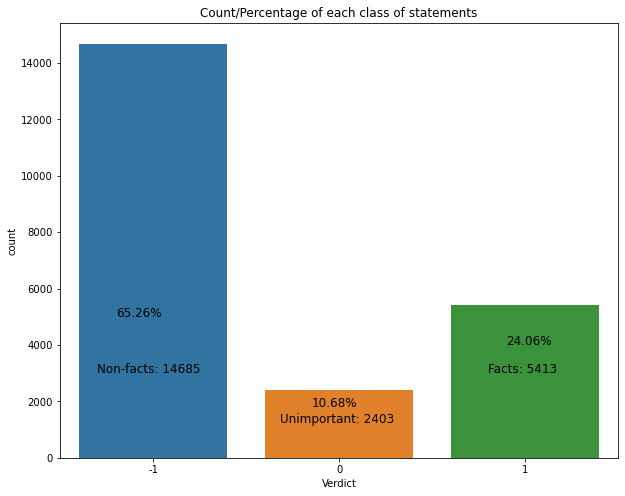

In [2]:
df = pd.read_csv('train.csv') # df forms our training dataset

non_fact_statements = df.loc[df['Verdict'] == -1]
unimportant_statements = df.loc[df['Verdict'] == 0]
fact_statements = df.loc[df['Verdict'] == 1]

# Percentage of each class
non_fact_percent = round(len(non_fact_statements)/len(df)*100,2)
unimportant_percent = round(len(unimportant_statements)/len(df)*100,2)
fact_percent = round(len(fact_statements)/len(df)*100,2)


fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x='Verdict', data=df)
plt.annotate(f'Non-facts: {len(non_fact_statements)}', 
             xy=(-0.3, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)

plt.annotate(f'Unimportant: {len(unimportant_statements)}', 
             xy=(0.68, 1250), # xy = (x dist from 0, y dist from 0)
            size=12)
plt.annotate(f'Facts: {len(fact_statements)}', 
             xy=(1.8, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)


plt.annotate(f'{non_fact_percent}%', xy=(-0.2, 5000),size=12)
plt.annotate(f'{fact_percent}%', xy=(1.9, 4000),size=12)
plt.annotate(f'{unimportant_percent}%', xy=(0.85, 1800),size=12)
ax.set_title('Count/Percentage of each class of statements')

###  From the graph countplot shown above, we can see that there is class imbalance, whereby 65.26% of the training data belonging to label -1, and 24.06% in label 1 and finally, 10.68% in label 0.

- We will look towards using removal of duplicates and data with contradictory labels to clip to the minority class to try to increase the generalization of the baseline models

# Summary of Preprocessing data

- Based on testing F1 score on kaggle with baseline Logistic Regression / Naive Bayes MultinomialNB model, we try to see if our efforts at preprocessing can help improve baseline score.
- TfidfVectorizer and CountVectorizer with ngram_range = (1,1) was used to check the results

Preprocessing tried:
- Casefolding & MinMaxScaler() for data normalization **(good)** - helped with improving LogisticRegression (tfidf) from f1 of 0.79862 to 0.8153
- Removal of duplicates and clipping data with contradicting labels to minority class of 0 **(good)** - helped with model generalization of LogisticRegression (tfidf) from 0.8153 to 0.82531, highest baseline score from just preprocessing.
- Lemmatization (with POS tagging)
- Removal of stopwords
- Removal of punctuations

For lemmatization, removal of stopwords and punctuations, they were bad for model generalization as they led to decreased f1 score across the board, and hence will not be pursued for the best model.

### In summary, the best baseline model score resulting from preprocessing ended up at 0.82531.

# Summary of Feature Engineering

We perform feature engineering on both the training and test datasets to ensure that the model have the same treatment when predicting the labels in the test set. In addition, we must use a MinMaxScaler() for data normalization to ensure that there are no scale-dominant feature during model training that could lead to bias.

The feature engineering was performed on the best model previously of LogisticRegression at 0.82531 from preprocessing.

Feature Enginering tried:
- Text Subjectivity
- Text Polarity
- Counts of different types of POS Tags by a custom defined function **(good) --> improved test f1 score from 0.82531 to 0.84159.**
- Dialog & narrative parser by custom defined function (good)
- Unique words in sentence ratio **(good) --> improve test f1 score from 0.84159 to 0.85446**
- Stop words in sentence ratio **(good) -->  improve test f1 score from 0.84159 to 0.85446**
- Counts of punctuaton within the sentence



**Of which, only POS tagging, dialog & narrative parsing and unique/stopwords ratio for each sentence had helped to boost the overall performance of baseline Logistic Regression model from a score of 0.82531 to a score of 0.85446, representing a ~2.9% increase in test f1_score.** Hence, moving forward with hyper-parameter tuning, we will use datasets and pipelines that make adjustments to both the training and test datasets of interest before running different parameters for our models to get the best ones.




# Summary of cross-validation & hyperparameter tuning

### Hyper-parameter tuning was performed for the following models:
1. Naive Bayes Model (e.g alpha of NB model)
2. Logistic Regression Model (e.g regularization constant, type of regularization penalty)
3. Choice of TfidfVectorizer and CountVectorizer Parameters (e.g ngram_range)

For this task, we will need to build data pipelines for our hyperparameter tuning.

### Model Selection and Usage of Pipeline (IMBLEARN):

<u>Train Test Split</u>
- stratified train/test split as peformed to maintain similar target variable distribution in both train & test set that is required for cross-validation within the pipeline.
- a 15% test split was selected by default to check validation loss/f1_score.

<u>Preprocess both training and test datasets for fairness</u>
- Based on our best performing model, we will perform the following on initial data in this sequence - **Preprocess: remove duplicates & data with contradicting labels -> Feature Engineering: POS tagging -> dialog & narrative parser -> unique/stopwords ratio -> followed by MinMaxScaler() for data normalization.**

<u>Hyper-parameter tuning:</u>
- GridSearchCV is used to tune various model parameters, we will use a 15% validation split.
- Models used will include: Naive Bayes, Logistic Regression.
- 5-fold cross validation will be used to search for the best parameters for each model.

<u>Evaluation Metric:</u>
- The trained model should have a high cross-validated high f1 score.
- By looking at the data from exploratory data analysis (EDA) previously, there is only a slight degree of imbalance in the dataset. Hence, the micro-average/weighted-macro can be used as a suitable scoring metric (credit: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/24051#24051)


<u>Sampling Methods:</u>
- We can see that here is some imbalance in the training data, namely minority in unimportant/non-factual statements. Hence, we make use of OverSampler to see if it can improve metric scoring for the models in cross-validation, and eventually on the test dataset on kaggle.

## We specify a ColumnTransformer that will be utilized within the pipeline to perform the following:

1. TfidfVectorizer / CountVectorizer within our pipeline, only on the 'Text' training column
2. MinMaxScaler() across all columns in the columns after tfidfvectorizer/countvectorizer is used.


## Define RandomOverSampler that could be used for not majority class.
- We will utilize only one form of resampling strategy to see if it helps our predictions on the unseen test data set and also on the cross-validated f1-score.
- Oversampling is the choice of selection and it is a technique used to handle class imbalance, which occurs when the number of examples in one class if significantly higher/lower than the number of examples in other classes.
- It involves increasing the number of examples in the minority class to balance the class distribution, by duplicating existing examples. SMOTE could also have been used, but it might not be the best, as we can further utilize libraries such as nlpaug which can help to augment better structured sentences with the help of large language models.
- For the purpose of this project, we will simply duplicate samples from the minority class to fulfil our purpose.

## Some benefits could include:
- Improved model performance by reducing bias to majority class
- Reduced overfitting from memorizing th training data.
- Better generalization




# Building a basic multilayer perception
- We will utilize a total of 3 hidden layers (256,128,64 units respectively), 1 input & output layer (3 units).
- Since it is a multiclass problem, we utilize softmax as the activation for the output layer. Relu activation is utilized for the rest of the hidden layers.
- We utilize l2 regularization to prevent overfitting by specifying a kernel regularizer at each layer. We search for the best regularization constant to be used in the GridSearchCV
- KerasClassifer is used as a wrapper for the Sequential model so that it can be used as an estimator and to provides a unified interface for use with GridSearchCV.
- We utilize BatchNormalization layers in between hidden layers to prevent the problem of vanishing gradients and exploding gradients during backpropagation, which can help to speed up training due to similar data scales and improve generalization by reducing overfitting.
- We monitor the validation loss of the neural network training to ensure that there are no overfitting to the training data. To handle this, we utilize EarlyStopping callback with patience of 3.

# Summary of results

In [3]:
resultdict_copy = {'Logistic Regression (tfidf, no resampling)': [{'columntransform__vect__ngram_range': (1,
    1),
   'columntransform__vect__norm': 'l2',
   'lr__C': 1.0000000000000002,
   'lr__penalty': 'l2'},
  0.7634632549836359],
 'Logistic Regression (tfidf, oversample)': [{'columntransform__vect__ngram_range': (1,
    2),
   'columntransform__vect__norm': 'l2',
   'lr__C': 1.0000000000000002,
   'lr__penalty': 'l2'},
  0.7411484677179411],
 'Logistic Regression (countvec, no resampling)': [{'columntransform__vect__analyzer': 'word',
   'columntransform__vect__ngram_range': (1, 2),
   'lr__C': 0.6000000000000001,
   'lr__penalty': 'l2'},
  0.7741743528711693],
 'Logistic Regression (countvec, oversample)': [{'columntransform__vect__ngram_range': (1,
    2),
   'lr__C': 0.6000000000000001,
   'lr__penalty': 'l2'},
  0.76316572448676],
 'Naive Bayes (tfidf, no resampling)': [{'columntransform__vect__ngram_range': (1,
    1),
   'columntransform__vect__norm': 'l2',
   'nb__alpha': 0.2},
  0.7479916691460875],
 'Naive Bayes (tfidf, oversample)': [{'columntransform__vect__ngram_range': (1,
    2),
   'columntransform__vect__norm': 'l2',
   'nb__alpha': 0.2},
  0.7185361499553704],
 'Naive Bayes (countvec, no resampling)': [{'columntransform__vect__analyzer': 'word',
   'columntransform__vect__ngram_range': (1, 2),
   'nb__alpha': 0.4},
  0.758405236536745],
 'Naive Bayes (countvec, oversample)': [{'columntransform__vect__analyzer': 'word',
   'columntransform__vect__ngram_range': (1, 2),
   'nb__alpha': 0.2},
  0.7194287414459983]}

sortedresults = sorted([[k,v[0],v[1]] for k, v in resultdict_copy.items()], key = lambda x: x[2], reverse = True)
res = pd.DataFrame(sortedresults, columns = ['Model','Best Params','15% Validation Set F1 Score'])

from IPython.core.display import HTML
display(HTML(res.to_html()))

,Model,Best Params,15% Validation Set F1 Score
0,"Logistic Regression (countvec, no resampling)","{'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}",0.774174
1,"Logistic Regression (tfidf, no resampling)","{'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}",0.763463
2,"Logistic Regression (countvec, oversample)","{'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}",0.763166
3,"Naive Bayes (countvec, no resampling)","{'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.4}",0.758405
4,"Naive Bayes (tfidf, no resampling)","{'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}",0.747992
5,"Logistic Regression (tfidf, oversample)","{'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}",0.741148
6,"Naive Bayes (countvec, oversample)","{'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.2}",0.719429
7,"Naive Bayes (tfidf, oversample)","{'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}",0.718536


### Using the top 4 models of cross-validation F1-score, we then use those parameters and train a new model on the full training set, and check the respective test f1_score on kaggle.

- Results show that the Logistic Regression (tfidf) with no resampling performed the best out of all the models, and hence will be used to output the results into excel

In [4]:
#loading the english language small model of spacy and retrieve the stopwords
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

C:\Users\Gary2\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
# write a function that generally takes in test dataframe and generates the verdict column in a new .csv file
def generate_result(test, y_pred, filename):
    """generate csv file based on the y_pred"""
    # test is already the dataframe that will open the file
    test['Verdict'] = pd.Series(y_pred)
    test_output = test.drop(columns=['Text']) # drop the Text column
    # Our final output file should have sentence_id, and verdict only
    test_output.to_csv(filename,index=False)

In [6]:
# Getting our final training data ready:
train_df = pd.read_csv('train.csv')

# Define the necessary dataframes to be used.
test_df = pd.read_csv('test.csv')

# to be performed only for training data to improve quality of training dataset.
def casefold_and_remove_duplicates_and_contradicts(df):
    # Store a copy of the original df to be used later.
    df_original = df.copy()
    
    # first convert our Text column from object to string
    df['Text'] = df['Text'].astype('string')
    df_original['Text'] = df_original['Text'].astype('string')
    # Do case folding by using map & lower function
    df['Text']=df['Text'].map(str.lower)
    df_original['Text']=df_original['Text'].map(str.lower)
    
    ################################### START TO HANDLE DATA W/ CONTRADICTING LABEL ##########################
    
    # Start to remove exact duplicates where text and label are the same, as it could lead to overfitting.
    df2 = df.groupby(['Text', 'Verdict']).size().reset_index(name='counts')
    df2 = df2.sort_values('counts',ascending=False)
    
    # Remove contradicting labels for the same statement
    contradicting_label_text_df = df2.loc[df2['Text'].duplicated(),:]
    # for all text data that we see in contradicting_label_text_df,
    # decide how to fix the labels for such data, since there are only 7 of such occurrences
    all_contradicting_label_text_df = pd.DataFrame()

    for index,row in contradicting_label_text_df.iterrows():
        df_to_append = df_original.loc[df_original.Text == row['Text']]
        all_contradicting_label_text_df = pd.concat([all_contradicting_label_text_df, df_to_append])
        
    # pad the observations to the minority. In addition, this will also result in help in the data imbalance.
    index_to_update_verdict = [] # store all the indexes to be updated for verdict in training data set
    
    for index, row in contradicting_label_text_df.iterrows():
        # print(row['Text'])
        # print(df.loc[df['Text'] == row['Text']].index)
        index_to_update_verdict.extend(df_original.loc[df_original['Text'] == row['Text']].index)

    # Loop through the indexes to update the verdict column for these indexes in df_original
    for index in index_to_update_verdict:
        df_original.loc[df_original.index == index, ['Verdict']] = 0
    
    ################################### END OF HANDLING DATA W/ CONTRADICTING LABEL ##########################
    
    ################################### START TO HANDLE DUPLICATED DATA ##########################
    # After handling data with contradicting label, find the new df2 to remove duplicates again
    new_df = df_original.drop_duplicates(keep='first', subset=['Text'])
    
    # return the preprocessed new_df
    return new_df
    
    
# Define a function to count the Part of Speech categories in each sentence, and apply it to a dataframe
def pos_count(sent):
    nn_count = 0   #Noun
    pr_count = 0   #Pronoun
    vb_count = 0   #Verb
    jj_count = 0   #Adjective
    uh_count = 0   #Interjection
    cd_count = 0   #Numerics
    
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    for token in sent:
            if token[1] in ['NN','NNP','NNS']:
                nn_count += 1
    if token[1] in ['PRP','PRP$']:
                pr_count += 1
    if token[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                vb_count += 1
    if token[1] in ['JJ','JJR','JJS']:
                jj_count += 1
    if token[1] in ['UH']:
                uh_count += 1
    if token[1] in ['CD']:
                cd_count += 1
    return pd.Series([nn_count, pr_count, vb_count, jj_count, uh_count, cd_count])

def dialog_parser(text):
    
    tokenized = nltk.word_tokenize(text)
    
    # let's set up some lists to hold our pieces of narrative and dialog
    parsed_dialog = []
    parsed_narrative = []
    
    # and this list will be a bucket for the text we're currently exploring
    current = []
    # now let's set up values that will help us loop through the text
    length = len(tokenized)
    found_q = False
    counter = 0
    quote_open, quote_close = '``', "''"
    # now we'll start our loop saying that as long as our sentence is...
    while counter < length:
        word = tokenized[counter]
        # until we find a quotation mark, we're working with narrative
        if quote_open not in word and quote_close not in word:
            current.append(word)
        # here's what we do when we find a closed quote
        else:
            # we append the narrative we've collected & clear our our
            # current variable
            parsed_narrative.append(current)
            current = []
            
            # now current is ready to hold dialog and we're working on
            # a piece of dialog
            current.append(word)
            found_q = True
            # while we're in the quote, we're going to increment the counter
            # and append to current in this while loop
            while found_q and counter < length-1:
                counter += 1
                if quote_close not in tokenized[counter]:
                    current.append(tokenized[counter])
                else:
                    # if we find a closing quote, we add our dialog to the
                    # appropriate list, clear current and flip our found_q
                    # variable to False
                    current.append(tokenized[counter])
                    parsed_dialog.append(current)
                    current = []
                    found_q = False
        # increment the counter to move us through the text
        counter += 1
    
    if len(parsed_narrative) == 0:
        parsed_narrative.append(current)
    
    mean_dialog_word_len = 0
    
    if len(parsed_dialog) > 0:
        for text in parsed_dialog:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_dialog_word_len += len(join_text.split())
        
        mean_dialog_word_len /= float(len(parsed_dialog))
    
    mean_narrative_word_len = 0
    
    if len(parsed_narrative) > 0:
        for text in parsed_narrative:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_narrative_word_len += len(join_text.split())
        
        mean_narrative_word_len /= float(len(parsed_narrative))
    return len(parsed_dialog), len(parsed_narrative), mean_dialog_word_len, mean_narrative_word_len


# Counting all unique words in a sentence
def count_unique_words(text):
    return len(set(text.split()))

# Counting all words in a sentence
def count_words(text):
    return len(text.split())

def count_stopwords(text):
    word_tokens = word_tokenize(text)
    stop_words = [w for w in word_tokens if w in sw_spacy]
    return len(stop_words)

# Define the column names to be inserted in both training and testing data and computed together 
POS_columns = ['nn_count', 'pr_count', 'vb_count', 'jj_count','uh_count', 'cd_count']
dialog_narrative_cols = ["num_dialog", "num_narrative"]
combined_cols = POS_columns + dialog_narrative_cols

# final column names for test & train data set
combined_cols_v2 = combined_cols + ['unique_vs_words','stopwords_vs_words']


# apply on training dataset our feature engineering
def open_df_and_return_df_POS_dialognarrative_ratios(df):
    df_copy = df.copy() # make a copy so that we do not make edits on the current version.
    # Feature: Apply POS tagging, and dialog / narrative parsing.
    df_copy[POS_columns] = df_copy['Text'].apply(pos_count)
    df_copy[dialog_narrative_cols[0]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[0])
    df_copy[dialog_narrative_cols[1]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[1])
    
    # apply word count/stopword count ratios on our dataframe
    df_copy['word_count'] = df_copy['Text'].apply(lambda x: count_words(x))
    df_copy['unique_word_count'] = df_copy['Text'].apply(lambda x: count_unique_words(x))
    df_copy['stopword_count'] = df_copy['Text'].apply(lambda x: count_stopwords(x))
    
    # Feature: unique words ratio in sentence
    df_copy['unique_vs_words'] = df_copy['unique_word_count']/df_copy['word_count']
    # Feature: stopwords ratio in sentence
    df_copy['stopwords_vs_words'] = df_copy['stopword_count']/df_copy['word_count']
    
    # Drop unnecessary columns inplace
    df_copy.drop(columns=['word_count','unique_word_count','stopword_count'], inplace=True)
    # df_copy.drop(columns=['word_count','unique_word_count','stopword_count','char_count'], inplace=True)
    return df_copy


# Casefold & remove duplicates first:
train_df_v1 = casefold_and_remove_duplicates_and_contradicts(train_df)
train_df_final = open_df_and_return_df_POS_dialognarrative_ratios(train_df_v1)
train_df_final.head()


,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0,0,1,1.000000,0.625000
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0,0,1,0.875000,0.687500
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0,0,1,0.931034,0.758621
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0,0,1,0.885714,0.685714
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0,0,1,0.866667,0.466667


# Handle Test Data

In [7]:
# apply the following functions to find our ratios of uniquewords/total words and stopwords/total words

# apply on test dataset
def open_testdf_and_return_testdf_casefold_POS_dialognarrative_ratios(df):
#     df = pd.read_csv('test.csv')
    df_copy = df.copy()
    df_copy['Text'] = df_copy['Text'].astype('string')
    df_copy['Text'] = df_copy['Text'].map(str.lower)
    # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
    df_copy[POS_columns] = df_copy['Text'].apply(pos_count)
    df_copy[dialog_narrative_cols[0]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[0])
    df_copy[dialog_narrative_cols[1]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[1])
    # df_copy['char_count'] = df_copy['Text'].apply(lambda x: count_chars(x))
    df_copy['word_count'] = df_copy['Text'].apply(lambda x: count_words(x))
    df_copy['unique_word_count'] = df_copy['Text'].apply(lambda x: count_unique_words(x))
    df_copy['stopword_count'] = df_copy['Text'].apply(lambda x: count_stopwords(x))
    df_copy['unique_vs_words'] = df_copy['unique_word_count']/df_copy['word_count']
    df_copy['stopwords_vs_words'] = df_copy['stopword_count']/df_copy['word_count']
    # df_copy['avg_wordlength'] = df_copy['char_count']/df_copy['word_count']
    
    # Drop unnecessary columns inplace
    df_copy.drop(columns=['word_count','unique_word_count','stopword_count'], inplace=True)
    # df_copy.drop(columns=['word_count','unique_word_count','stopword_count','char_count'], inplace=True)
    return df_copy

# TESTING
test_df_POS_dialog_narrative_ratios = open_testdf_and_return_testdf_casefold_POS_dialognarrative_ratios(test_df)
test_df_POS_dialog_narrative_ratios.head()

,Sentence_id,Text,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,1,"you know, i saw a movie - ""crocodile dundee.""",2,0,0,0,0,0,1,1,1.000000,0.333333
1,2,we're consuming 50 percent of the world's coca...,3,0,0,0,0,0,0,1,1.000000,0.625000
2,3,that answer was about as clear as boston harbor.,3,0,0,0,0,0,0,1,0.888889,0.555556
3,4,let me help the governor.,1,0,0,0,0,0,0,1,1.000000,0.400000
4,5,we've run up more debt in the last eight years...,6,0,0,0,0,0,0,1,0.954545,0.636364


In [8]:
# Define a function to take a training dataframe and output the sentences and the corresponding labels
def get_sentences_and_label(traindf):
    sentences = traindf['Text']
    labels = traindf['Verdict']
    return sentences, labels


In [9]:
train_df_final.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0,0,1,1.000000,0.625000
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0,0,1,0.875000,0.687500
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0,0,1,0.931034,0.758621
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0,0,1,0.885714,0.685714
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0,0,1,0.866667,0.466667


In [10]:
# specify train_df_final_v2 which drops sentence id and text column
train_df_final_v2 = train_df_final.drop(columns=['Sentence_id','Text','Verdict'])

print(train_df_final_v2.columns)

# specify test_df_POS_dialog_narrative_ratios
test_df_final_v2 = test_df_POS_dialog_narrative_ratios.drop(columns=['Sentence_id','Text'])
print(test_df_final_v2.columns)

Index(['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count',
       'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words'],
      dtype='object')
Index(['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count',
       'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words'],
      dtype='object')


In [11]:
test_df_POS_dialog_narrative_ratios.head()

,Sentence_id,Text,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,1,"you know, i saw a movie - ""crocodile dundee.""",2,0,0,0,0,0,1,1,1.000000,0.333333
1,2,we're consuming 50 percent of the world's coca...,3,0,0,0,0,0,0,1,1.000000,0.625000
2,3,that answer was about as clear as boston harbor.,3,0,0,0,0,0,0,1,0.888889,0.555556
3,4,let me help the governor.,1,0,0,0,0,0,0,1,1.000000,0.400000
4,5,we've run up more debt in the last eight years...,6,0,0,0,0,0,0,1,0.954545,0.636364


## Based on cross-validated results and top 4 model results, the best performing model and hyper parameters that returned the highest test f1_score on KAGGLE was:

Logistic Regression (tfidf, no resampling)	{'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}

In [ ]:
sentences, labels = get_sentences_and_label(train_df_final)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) # best hyperparameter setting

# Train model on full training dataset and make an array
X_train_tfidf = tfidf_vectorizer.fit_transform(sentences).toarray() # perform fit_transform

# Get sentences from test data and transform with tfidf and make an array
X_test_tfidf = tfidf_vectorizer.transform(test_df['Text']).toarray()

# Convert the above list to a DataFrame
train_tfidf = pd.DataFrame(X_train_tfidf)
train_tfidf.reset_index(inplace=True, drop=True)
test_tfidf = pd.DataFrame(X_test_tfidf)
test_tfidf.reset_index(inplace=True, drop=True)

train_df_final_v2.reset_index(inplace=True,drop=True)
test_df_final_v2.reset_index(inplace=True,drop=True)






# train_POS_dialog_narrative_ratios_feature = new_df_POS_dialog_narrative_ratios[combined_cols_v2]
# train_POS_dialog_narrative_ratios_feature.reset_index(inplace=True, drop=True)
# test_POS_dialog_narrative_ratios_feature = test_df_POS_dialog_narrative_ratios[combined_cols_v2]
# test_POS_dialog_narrative_ratios_feature.reset_index(inplace=True,drop=True)

# Merge the tfidf feature and other feature engineered variables using pd.merge
X_train = pd.merge(train_tfidf, train_df_final_v2, left_index=True, right_index=True)
X_test = pd.merge(test_tfidf, test_df_final_v2,left_index=True, right_index=True)

print(X_train.shape)
print(X_test.shape)

# MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
sc = MinMaxScaler()

# Perform normalization
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Train Logistic Regression classifier with data
LR_classifier = LogisticRegression(random_state=randomseed, solver='liblinear',C=1,penalty='l2').fit(X_train_scaled, labels)

# Do predictions on X_test_scaled
y_pred_full = LR_classifier.predict(X_test_scaled)

# Generate the csv file to submit to kaggle
generate_result(test_df_POS_dialog_narrative_ratios.drop(columns=combined_cols_v2), y_pred_full, filename)

# END